# Training with just Deep Neural Networks and Mutual Information

In the previous notebook (Mutual Information), we have selected 33 features that are correlated by a greather than 0.5 mutual information. These descriptors are:  

* Most correlated features given by Mutual Information:

In [99]:
most_correlated_33 = [
 'piPC4',
 'piPC9',
 'SlogP_VSA8',
 'piPC3',
 'piPC5',
 'SlogP_VSA6',
 'C2SP2',
 'nAromAtom',
 'AXp-3d',
 'C1SP2',
 'nBondsA',
 'nAromBond',
 'piPC8',
 'TpiPC10',
 'ATSC3c',
 'AXp-6d',
 'n6Ring',
 'piPC6',
 'NaasC',
 'piPC10',
 'Xch-6d',
 'Xp-7dv',
 'CIC1',
 'MATS3c',
 'C1SP3',
 'SssCH2',
 'AXp-4d',
 'SMR_VSA3',
 'PEOE_VSA11',
 'AATSC2se',
 'GATS4are',
 'PEOE_VSA5',
 'AATS4d']



## Used libraries

In [100]:
import sys
sys.path.append('/content/drive/MyDrive/Colaboracion_Quimica/Main_Codes/AutoEncoders/AmaroX/AmaroX')

In [101]:
! pip install python-telegram-bot

In [102]:
from ai_functions import *
from ai_models import *
from utilities import *
from data_manipulation import *
import pandas as pd
import sklearn

## Data

The data presented here corresponds to molecules with their SMILE representation and descriptors, along with the biological activity. Let's first do a quick view of the data shape.

### Downloading the data

In [103]:
! gdown --id 1cHM9neEhTOZ82UU9HaZkdGdlwE1d4SJT
! gdown --id 1wZp9pou63ElEYyGGjBeC2pDtscgRgCpj

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cHM9neEhTOZ82UU9HaZkdGdlwE1d4SJT
To: /content/data.xlsx
100% 835k/835k [00:00<00:00, 74.6MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wZp9pou63ElEYyGGjBeC2pDtscgRgCpj
To: /content/Actividad.xlsx
100% 9.40k/9.40k [00:00<00:00, 21.4MB/s]


The _data.xlsx_ file contains all the molecular descriptors from the molecule, along with a SMILE representation.

In [104]:
compounds_md = pd.read_excel("data.xlsx")
activity = pd.read_excel("Actividad.xlsx")

In [105]:
compounds_md.head()

,Cmpd,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,Compuesto original,O=C(N/1)/C(SC1=N/C2=NC3=CC=C(F)C=C3S2)=C/N4CCN...,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,3,34.64084,2.428932,4.709973,34.64084,...,10.158170,78.17227,405.1093,8.619347,2138,39,146,171,8.361111,5.750000
1,Compound 3,O=C1NC2=CC=C([H])C=C2/C1=N\C3=CC=CC(Br)=N3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,23.43385,2.452376,4.754134,23.43385,...,9.792612,65.48686,300.9851,11.576350,599,26,96,113,5.166667,3.916667
2,Compound 4,O=C1NC2=CC=CC=C2/C1=N\C3=NC4=CC(OCC)=CC=C4S3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,30.43085,2.474251,4.745881,30.43085,...,10.101640,73.78306,323.0728,8.974246,1245,35,126,151,6.138889,5.027778
3,Compound 8,O=C1NC2=CC=C(Br)C=C2/C1=N\C3=CC=CC(F)=N3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,24.52891,2.46582,4.787297,24.52891,...,9.873183,66.82214,318.9757,12.268290,693,28,102,120,6.027778,4.083333
4,Compound 9,O=C1NC2=CC=C(Br)C=C2/C1=N/C3=CC([N+]([O-])=O)=...,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,27.00118,2.467278,4.80069,27.00118,...,9.972407,69.29945,345.9702,12.356080,929,32,112,132,7.138889,4.527778


In [106]:
compounds_md.shape

(71, 1828)

In [107]:
activity.head()

,Activity
0,5.005513
1,4.381642
2,4.114064
3,5.012402
4,5.047677


In [108]:
activity.shape

(71, 1)

* The variable _x_ are the molecular descriptors, we're only interested in numerical properties:

In [109]:
x = compounds_md.copy()
x = x.select_dtypes("number")

## Selecting just the 33 features



We have reduced the dimensio of 1824 to just 1218 by selecting numerical features:

In [110]:
x.shape

(71, 1218)

We select the 33 features:

In [111]:
x = x[most_correlated_33]
x.head()

,piPC4,piPC9,SlogP_VSA8,piPC3,piPC5,SlogP_VSA6,C2SP2,nAromAtom,AXp-3d,C1SP2,...,MATS3c,C1SP3,SssCH2,AXp-4d,SMR_VSA3,PEOE_VSA11,AATSC2se,GATS4are,PEOE_VSA5,AATS4d
0,5.370347,7.279480,10.21662,4.790612,5.856682,34.29660,7,9,0.181038,2,...,-0.242960,6,3.810264,0.115159,20.100590,5.167652,0.005271,0.593295,0.0,2.683761
1,5.129899,6.897579,0.00000,4.553877,5.672034,52.06017,9,12,0.177669,3,...,0.059362,0,0.000000,0.114655,4.983979,5.817863,0.014515,1.159876,0.0,3.488889
2,5.561883,7.716910,10.21662,4.913574,6.122493,47.45697,12,15,0.171496,1,...,-0.037510,2,0.612854,0.109821,4.983979,0.000000,0.006369,0.950828,0.0,3.590909
3,5.181784,6.988759,0.00000,4.600158,5.750189,45.86333,9,12,0.177338,3,...,0.021262,0,0.000000,0.112165,4.983979,5.817863,0.017495,1.026392,0.0,3.644444
4,5.254888,7.122564,0.00000,4.686750,5.832615,45.99380,9,12,0.177613,3,...,-0.038070,0,0.000000,0.110931,4.983979,5.817863,0.017275,1.229834,0.0,3.528302


In [112]:
x = np.array(x)
x.shape

(71, 33)

In [113]:
y = np.array(activity)[:, 0]
y.shape

(71,)

## Normalize features

In [114]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

In [115]:
#x = scaler.fit_transform(x)

## Select the most correlated features using Pearson

In [116]:
correlacion = np.corrcoef(x, y, rowvar=False)

In [117]:
corr_y = np.abs(correlacion[:-1, -1])

In [118]:
corr_y

array([0.22322579, 0.26173344, 0.35357963, 0.24799011, 0.19683997,
       0.51759584, 0.30664738, 0.36723979, 0.20015349, 0.51034028,
       0.33462881, 0.33462881, 0.23142834, 0.25149966, 0.27331035,
       0.10626275, 0.16663422, 0.19773354, 0.33493839, 0.28558727,
       0.06666813, 0.14918857, 0.41582839, 0.32707221, 0.16744214,
       0.08391252, 0.10392922, 0.30831337, 0.15803106, 0.61502212,
       0.50472703, 0.15690143, 0.07257079])

In [179]:
ind = np.where(corr_y >=0)
ind

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),)

In [180]:
corr_y[ind]

array([0.22322579, 0.26173344, 0.35357963, 0.24799011, 0.19683997,
       0.51759584, 0.30664738, 0.36723979, 0.20015349, 0.51034028,
       0.33462881, 0.33462881, 0.23142834, 0.25149966, 0.27331035,
       0.10626275, 0.16663422, 0.19773354, 0.33493839, 0.28558727,
       0.06666813, 0.14918857, 0.41582839, 0.32707221, 0.16744214,
       0.08391252, 0.10392922, 0.30831337, 0.15803106, 0.61502212,
       0.50472703, 0.15690143, 0.07257079])

In [181]:
most_correlated_33[29]

'AATSC2se'

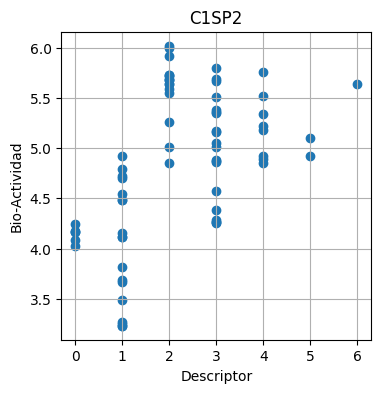

In [182]:
n = 9
plt.figure(figsize = (4,4))
plt.scatter(x[:, n], y)
plt.grid()
plt.xlabel('Descriptor')
plt.ylabel('Bio-Actividad')
plt.title(most_correlated_33[n])
plt.show()

In [183]:
6# Create and fit the model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x[:, ind[0]], y)

# Get coefficients and bias
coefficients = model.coef_  # Array of 3 coefficients (one for each x variable)
bias = model.intercept_    # The bias term

print("Coefficients:", coefficients)
print("Bias (intercept):", bias)


Coefficients: [ 8.82876655e+00  5.00435518e+00  6.82035227e-02 -8.10748864e+00
 -3.39599502e+00  2.78932359e-02  1.82240678e-01 -2.25643296e-01
  1.59402830e+01  2.30624263e-01 -5.50753109e-02 -5.50753108e-02
  2.68531658e+00 -1.72981432e+01  4.17438271e-01 -6.32860048e+01
 -1.72504258e-01  7.44867828e+00  4.59519996e-01  4.03286014e+00
 -2.60916408e+00  6.67189818e-01  3.92969818e-01 -1.55778138e-01
 -3.32563501e-02  1.71105619e-01  6.48014464e+01  7.37176478e-02
 -3.58486369e-02  4.59647205e+00  1.34907987e+00 -5.34996454e-02
  6.55838254e-01]
Bias (intercept): 24.152272386717687


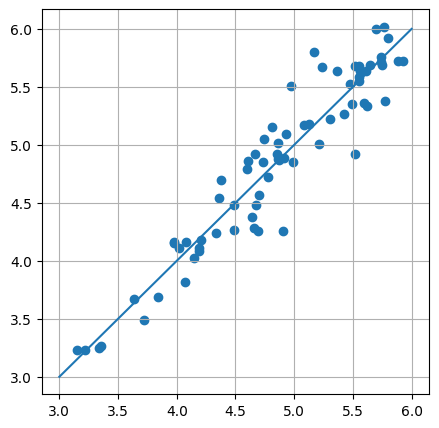

In [191]:
plt.figure(figsize = (5,5))
plt.plot([x for x in range(3,7)], [x for x in range(3,7)] )
plt.scatter( model.predict(x[:, ind[0]] ), y )
plt.grid()
plt.show()

In [185]:
model.predict(x[:, ind[0]]).shape

(71,)

In [186]:
metric_accuracy(y, model.predict(x[:, ind[0]]))

<tf.Tensor: shape=(), dtype=float64, numpy=96.33991513824395>

In [187]:
mape = lambda y_true, y_pred:  100 * np.mean(np.abs( (y_true - y_pred)/(y_true)  ))

In [188]:
mape(y, model.predict(x[:, ind[0]]))

np.float64(3.6600849396230895)

In [189]:
from sklearn.metrics import r2_score

In [190]:
r2_score(y, model.predict(x[:, ind[0]]))

0.9040631426717483

La actividad biológica en el conjunto de datos, puede escribirse de la forma:

$$\text{BA} =  [0.01818 * \text{SlogP_VSA6} +0.1924 * \text{C1SP2} -12.32 * \text{AATSC2se}] + 3.7148 $$